In [1]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print(device_lib.list_local_devices())


2024-04-21 20:13:52.675577: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-21 20:13:52.877319: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 20:13:53.839360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16389702123082534872
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10182721536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16165961699965209174
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-04-21 20:13:55.467222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:13:55.558333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:13:55.558733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:13:55.799604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:13:55.799998: I tensorflow/compile

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers


In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f4c1ff07cd0>)

In [4]:
train_data = pd.read_table('ratings.txt')

In [5]:
#총 리뷰 개수를 확인
print(len(train_data)) # 리뷰 개수 출력

200000


In [6]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [7]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [8]:
#결측값이 삭제된 후의 리뷰 개수를 확인
print(len(train_data)) # 리뷰 개수 출력

199992


In [9]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [10]:
from tqdm import tqdm
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [04:38<00:00, 718.29it/s]


In [11]:
train_data['tokenized']= tokenized_data

In [12]:
token_label_df= train_data[['tokenized','label']]


train_test_split

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['tokenized'])

train_size= int(len(token_label_df)*0.8)

shuffled_df= token_label_df.sample(frac=1, random_state=42)

train_data= shuffled_df[:train_size]
test_data= shuffled_df[train_size:]
train_x= pd.DataFrame(train_data['tokenized'])
train_y= pd.DataFrame(train_data['label'])
test_x= pd.DataFrame(test_data['tokenized'])
test_y= pd.DataFrame(test_data['label'])


In [14]:
train_x

,tokenized
189879,"[모피, 너무, 많이, 입, 고, 나오다, 불쾌하다]"
87482,"[결말, ㅠ, ㅠ, 메다, 비, 푸다, 포, 완전, 멋지다, ㅠ, 이제, 서다, 알..."
36369,"[타, 케, 모토, 노, 보루, 감독, ,, 최고, 걸작, 이다]"
82006,"[진짜, 인생, 애니메이션, 어리다, 땐, 상상력, 자극, 재밌다, 커서, 우정, ..."
89163,"[몇몇, 맞다, 않다, 전개도, 있다, 정도, 면, 훌륭하다, ., 우리, 이순신장..."
...,...
119323,"[젠장, 별, 1, 개도, 아깝다]"
75607,"[자다, 쌩, 기다, 투, 블럭, 소년, 깜찍하다, 붉다, 머리, 소녀]"
158227,"[형제, 애, ?, 뉴욕, 밤, 을, 지배, 과연, 누구, 지, ?, 어디, 초점,..."
101051,[Bad]


In [15]:
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


# 정수 인코딩
X_train_sequences = tokenizer.texts_to_sequences(train_x['tokenized'])
X_test_sequences = tokenizer.texts_to_sequences(test_x['tokenized'])

# 패딩
max_len = max(len(l) for l in X_train_sequences)  # 가장 긴 문장의 길이 계산
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)



DNN

In [16]:
# 모델 구성
vocab_size = len(tokenizer.word_index) + 1  # 단어 사전의 크기
embedding_dim = 100  # 임베딩 벡터의 차원

model = Sequential(
    [Embedding(vocab_size, embedding_dim, input_length=max_len),
     Dense(32,kernel_initializer='he_normal', bias_initializer='zeros',kernel_regularizer=l2(0.001)),
     BatchNormalization(),
     layers.ReLU(),
     Dropout(0.25),
     Dense(16,kernel_initializer='he_normal', bias_initializer='zeros',kernel_regularizer=l2(0.001)),
     BatchNormalization(),
     layers.ReLU(),
     Dropout(0.25),
     Dense(1, activation = 'sigmoid',kernel_initializer='he_normal', bias_initializer='zeros')]
)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 모델 훈련
history = model.fit(X_train_padded, train_y, epochs=50, batch_size=64, validation_split=0.2)

# 모델 평가
test_loss, test_acc = model.evaluate(X_test_padded, test_y)
print('Test Accuracy:', test_acc)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 95, 100)           5670600   
                                                                 
 dense (Dense)               (None, 95, 32)            3232      
                                                                 
 batch_normalization (Batch  (None, 95, 32)            128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 95, 32)            0         
                                                                 
 dropout (Dropout)           (None, 95, 32)            0         
                                                                 
 dense_1 (Dense)             (None, 95, 16)            528       
                                                        

2024-04-21 20:18:38.460983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:18:38.461482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:18:38.462070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:18:38.462966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:18:38.463612: I tensorflow/compile

Epoch 1/50


2024-04-21 20:18:39.972739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-21 20:18:40.030089: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4a5439c540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-21 20:18:40.030154: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-21 20:18:40.054938: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-21 20:18:40.098405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-04-21 20:18:40.184141: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-21 20:18:40.25274

2000/2000 [==============================] - 56s 27ms/step - loss: 0.7037 - accuracy: 0.5109 - val_loss: 0.6866 - val_accuracy: 0.5119
Epoch 2/50
2000/2000 [==============================] - 24s 12ms/step - loss: 0.6858 - accuracy: 0.5207 - val_loss: 0.6863 - val_accuracy: 0.5115
Epoch 3/50
2000/2000 [==============================] - 22s 11ms/step - loss: 0.6849 - accuracy: 0.5229 - val_loss: 0.6860 - val_accuracy: 0.5192
Epoch 4/50
2000/2000 [==============================] - 22s 11ms/step - loss: 0.6845 - accuracy: 0.5250 - val_loss: 0.6862 - val_accuracy: 0.5197
Epoch 5/50
2000/2000 [==============================] - 21s 10ms/step - loss: 0.6845 - accuracy: 0.5205 - val_loss: 0.6863 - val_accuracy: 0.5199
Epoch 6/50
2000/2000 [==============================] - 20s 10ms/step - loss: 0.6842 - accuracy: 0.5210 - val_loss: 0.6864 - val_accuracy: 0.5198
Epoch 7/50
2000/2000 [==============================] - 21s 10ms/step - loss: 0.6841 - accuracy: 0.5213 - val_loss: 0.6863 - val_accura

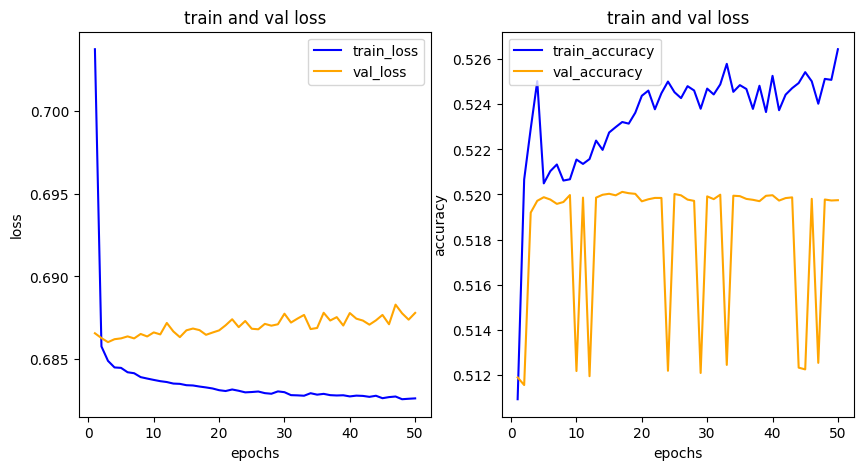

In [17]:
#학습결과 그려보기
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_accuracy')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_accuracy')
ax2.set_title('train and val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.legend()


plt.show()

RNN

In [18]:
model = Sequential(
    [Embedding(vocab_size, embedding_dim, input_length=max_len),
     SimpleRNN(32, dropout=0.2,kernel_regularizer=l2(0.001)),
     Dense(1, activation='sigmoid')
     ]
)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 모델 훈련
history = model.fit(X_train_padded, train_y, epochs=20, batch_size=512, validation_split=0.2)

# 모델 평가
test_loss, test_acc = model.evaluate(X_test_padded, test_y)
print('Test Accuracy:', test_acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 95, 100)           5670600   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5674889 (21.65 MB)
Trainable params: 5674889 (21.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
250/250 [==============================] - 62s 238ms/step - loss: 0.4905 - accuracy: 0.7874 - val_loss: 0.3969 - val_accuracy: 0.8419
Epoch 2/20
250/250 [==============================] - 49s 197ms/step - loss: 0.3340 - accuracy: 0.8743 - val_loss: 0.3796 - val_accur

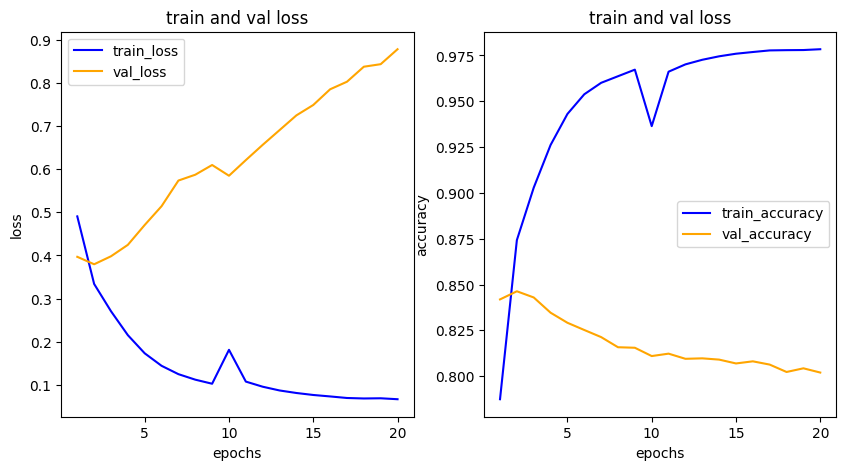

In [19]:
#학습결과 그려보기
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_accuracy')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_accuracy')
ax2.set_title('train and val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.legend()


plt.show()

LSTM

In [20]:
model = Sequential(
    [Embedding(vocab_size, embedding_dim, input_length=max_len),
     LSTM(32, dropout=0.2,kernel_regularizer=l2(0.001)),
     Dense(1, activation='sigmoid')
     ]
)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 모델 훈련
history = model.fit(X_train_padded, train_y, epochs=20, batch_size=512, validation_split=0.2)

# 모델 평가
test_loss, test_acc = model.evaluate(X_test_padded, test_y)
print('Test Accuracy:', test_acc)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 95, 100)           5670600   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5687657 (21.70 MB)
Trainable params: 5687657 (21.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
250/250 [==============================] - 21s 79ms/step - loss: 0.4706 - accuracy: 0.8037 - val_loss: 0.3768 - val_accuracy: 0.8431
Epoch 2/20
250/250 [==============================] - 10s 38ms/step - loss: 0.3270 - accuracy: 0.8699 - val_loss: 0.3594 - val_accurac

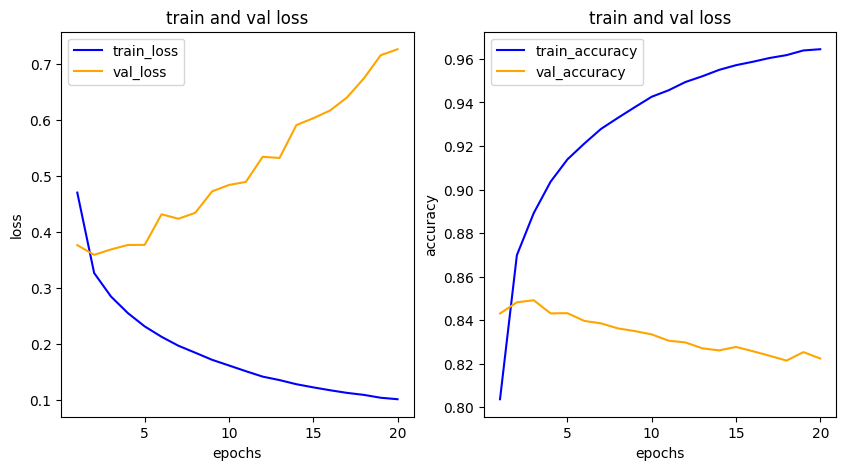

In [21]:
#학습결과 그려보기
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_accuracy')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_accuracy')
ax2.set_title('train and val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.legend()


plt.show()

word2vec 사용

In [22]:
#word2vec 학습
from gensim.models import Word2Vec

wvmodel= Word2Vec(token_label_df['tokenized'], vector_size=100, window=5, min_count=5, workers=4)


In [23]:
wvmodel.wv

In [24]:
#embedding vector 생성
vocab_size = len(tokenizer.word_index) + 1  # 단어 사전의 크기

embedding_matrix= np.zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
    if word in list(wvmodel.wv.index_to_key):
        embedding_matrix[i]= wvmodel.wv[word]

In [25]:
# 모델 구성

model= Sequential([
    Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(32, dropout=0.2,kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_padded, train_y, epochs=20, batch_size=512, validation_split=0.2)


Epoch 1/20
250/250 [==============================] - 6s 15ms/step - loss: 0.5402 - accuracy: 0.7708 - val_loss: 0.4607 - val_accuracy: 0.8054
Epoch 2/20
250/250 [==============================] - 3s 11ms/step - loss: 0.4424 - accuracy: 0.8111 - val_loss: 0.4171 - val_accuracy: 0.8195
Epoch 3/20
250/250 [==============================] - 3s 11ms/step - loss: 0.4186 - accuracy: 0.8214 - val_loss: 0.4012 - val_accuracy: 0.8263
Epoch 4/20
250/250 [==============================] - 3s 10ms/step - loss: 0.4039 - accuracy: 0.8275 - val_loss: 0.3919 - val_accuracy: 0.8333
Epoch 5/20
250/250 [==============================] - 3s 11ms/step - loss: 0.3951 - accuracy: 0.8318 - val_loss: 0.3871 - val_accuracy: 0.8342
Epoch 6/20
250/250 [==============================] - 3s 11ms/step - loss: 0.3889 - accuracy: 0.8342 - val_loss: 0.3814 - val_accuracy: 0.8379
Epoch 7/20
250/250 [==============================] - 3s 11ms/step - loss: 0.3841 - accuracy: 0.8376 - val_loss: 0.3788 - val_accuracy: 0.8392

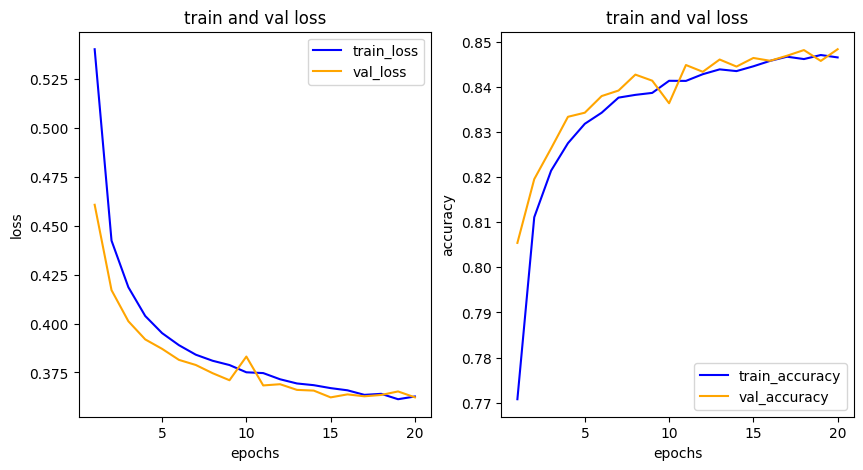

In [26]:
#학습결과 그려보기
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_accuracy')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_accuracy')
ax2.set_title('train and val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.legend()


plt.show()